This notebook contains the code for the meta-analysis of healthy lung data for ACE2, TMPRSS2, and CTSL. It contains the hold-out analysis for the complex model with interaction terms that was run on the cell-level data.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import patches
import seaborn as sns
import batchglm
import diffxpy.api as de
import patsy as pat
from statsmodels.stats.multitest import multipletests
import logging, warnings
import statsmodels.api as sm

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


'v0.7.3'

In [3]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study'

adata_diffxpy = '/storage/groups/ml01/workspace/malte.luecken/2020_cov19_study/COVID19_lung_atlas_revision_v3.h5ad'

output_folder = 'diffxpy_out/'

de_output_base = 'COVID19_lung_atlas_revision_v3_lung_cov19_poissonglm_smoking_holdouts_nUMIoffset_testInts'

# Read the data

In [4]:
adata = sc.read(adata_diffxpy)

In [5]:
adata

AnnData object with n_obs × n_vars = 1320896 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new'

In [6]:
adata.obs.age = adata.obs.age.astype(float)

In [7]:
adata.obs.dtypes

age                         float64
anatomical_region          category
donor                      category
last_author/PI             category
lung_vs_nasal              category
notes                      category
original_celltype_ann      category
sample                     category
sex                        category
smoking                    category
total_counts                float64
smoked_boolean             category
last_author_sample_name    category
ann_level_1                category
ann_level_2                category
ann_level_3                category
ann_level_4                category
ann_level_5                category
ann_highest_res               int64
ann_new                        bool
dtype: object

In [8]:
adata.obs['dataset'] = adata.obs['last_author/PI']

In [9]:
adata.obs.dataset.value_counts()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    95303
Spence                      78401
Barbry/Leroy                76981
Krasnow/Quake               60993
Meyer                       57020
Rawlins                     53409
Regev                       43527
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Misharin                    28329
Xavier/Regev                25552
Spira/Campbell              24455
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Schultze                    22641
Schiller                    20776
Nawijn                      18197
Teichmann                   12971
Kropski/Banovich_dnar        8359
Shalek                       7603
Linnarsson                   4640
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      2207
Schultze/Falk                1965
Beane         

# Filter the data

Keep only datsets with:
- more than 1 donor
- non-fetal
- lung

In [10]:
# Remove fetal datasets
dats_to_remove = set(['Rawlins', 'Spence', 'Linnarsson'])

In [11]:
dat = adata.obs.groupby(['donor']).agg({'sex':'first', 'age':'first', 'dataset':'first'})

# Single donor filter
don_tab = dat['dataset'].value_counts()
dats_to_remove.update(set(don_tab.index[don_tab == 1]))

In [12]:
dats_to_remove = list(dats_to_remove)
dats_to_remove

['Misharin', 'Spence', 'Linnarsson', 'Rawlins', 'Schultze/Falk']

In [13]:
adata = adata[~adata.obs.dataset.isin(dats_to_remove)].copy()

In [14]:
adata.obs.lung_vs_nasal.value_counts()

lung     1096604
nasal      57548
Name: lung_vs_nasal, dtype: int64

In [15]:
# Filter for only lung data
adata = adata[adata.obs.lung_vs_nasal.isin(['lung']),].copy()

In [16]:
adata

AnnData object with n_obs × n_vars = 1096604 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset'

In [17]:
adata.obs['sample'].nunique()
adata.obs['donor'].nunique()
adata.obs['dataset'].nunique()

309

185

24

# Binarize smoking status

In [18]:
adata.obs.smoking.value_counts()

never              575345
current            173020
nan                111184
former              53487
non-smoker          42367
never-smoker        33119
active              29396
smoked              28197
current/former      23573
heavy               15663
current/former?      5162
light                3316
Former               1385
Current               610
Never Smoker          426
Current Smoker        354
Name: smoking, dtype: int64

In [19]:
adata.obs['smoking_status'] = adata.obs.smoked_boolean
#adata.obs['smoking_status'] = [True if stat in ['current', 'smoked', 'active', 'former', 'heavy', 'light'] else False if stat in ['never', 'nonsmoker'] else "nan" for stat in adata.obs.smoking]

In [20]:
adata.obs.smoking_status.value_counts()

False    651257
True     334163
nan      111184
Name: smoking_status, dtype: int64

## Filter out data w/o smoking status

In [21]:
pd.crosstab(adata.obs.dataset, adata.obs.smoking)

smoking,Current,Current Smoker,Former,Never Smoker,active,current,current/former,current/former?,former,heavy,light,nan,never,never-smoker,non-smoker,smoked
dataset,,,,,,,,,,,,,,,,
Barbry/Leroy,0,0,0,0,0,0,0,0,16423,0,0,0,0,0,42367,0
Beane,0,0,0,0,0,305,0,0,581,0,0,0,0,0,0,0
Beane/Campbell,0,354,0,426,0,0,0,0,0,0,0,0,0,0,0,0
Eils/Conrad/Kreuter,0,0,0,0,0,11185,0,0,0,0,0,0,28593,0,0,0
Kaminski,0,0,0,0,0,0,23573,0,0,0,0,3850,67880,0,0,0
Koenigshoff,0,0,0,0,0,0,0,0,0,0,0,0,0,33119,0,0
Krasnow/Quake,0,0,0,0,0,0,0,0,7524,0,0,0,53469,0,0,0
Kropski/Banovich_dnar,0,0,0,0,0,0,0,0,0,0,0,0,2647,0,0,5712
Kropski/Banovich_vand,0,0,0,0,0,0,0,0,0,0,0,0,800,0,0,22485


In [22]:
adata = adata[~adata.obs.smoking_status.isin(['nan']),].copy()
adata

AnnData object with n_obs × n_vars = 985420 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status'

In [23]:
adata.obs.dataset.value_counts()
adata.obs['sample'].nunique()
adata.obs['donor'].nunique()

Regev/Rajagopal            322998
Meyer_b                    117535
Kaminski                    91453
Krasnow/Quake               60993
Barbry/Leroy                58790
Meyer                       57020
Misharin/Budinger           41266
Eils/Conrad/Kreuter         39778
Seibold                     36248
Whitsett/Xu_10X             34185
Koenigshoff                 33119
Lafyatis/Rojas              24220
Kropski/Banovich_vand       23285
Teichmann                   12971
Nawijn                      11110
Kropski/Banovich_dnar        8359
Schiller                     5162
Whitsett/Xu_dropSeq          3267
Mazzilli/Campbell/Beane      1995
Beane                         886
Beane/Campbell                780
Name: dataset, dtype: int64

286

164

# Check the data

In [24]:
np.mean(adata.X.astype(int) != adata.X)

0.0

In [25]:
for dat in adata.obs.dataset.unique():
    val = np.mean(adata[adata.obs.dataset.isin([dat]),:].X.astype(int) != adata[adata.obs.dataset.isin([dat]),:].X)
    if val != 0:
        print(f'dataset= {dat}; value= {val}')
        adata[adata.obs.dataset.isin([dat]),:].X[:20,:20].A

All counts are integers

# Fit models and perform DE

In [26]:
cluster_key = 'ann_level_2'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Myeloid',
 'Airway epithelium',
 'Alveolar epithelium',
 'Lymphoid',
 'Fibroblast lineage',
 'Blood vessels',
 'Submucosal Gland',
 'Smooth Muscle',
 'Lymphatics',
 'Mesothelium']

Calculate DE genes per cluster.

In [27]:
adata

AnnData object with n_obs × n_vars = 985420 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status'

In [28]:
adata.obs['total_counts_scaled'] = adata.obs['total_counts']/adata.obs['total_counts'].mean()

In [29]:
# Get interquartile range for ages to test
adata.obs.groupby(['donor']).agg({'age':'first'}).age.quantile([0.25,0.5,0.75])

0.25    30.75
0.50    49.50
0.75    62.50
Name: age, dtype: float64

In [30]:
formula = "1 + sex + age + sex:age + smoking_status + sex:smoking_status + age:smoking_status + dataset"
tested_coef = ["sex[T.male]", "age", "smoking_status[T.True]"]
dmat = de.utils.design_matrix(
    data=adata,
    formula="~" + formula,
    as_numeric=["age"],
    return_type="patsy"
)

to_test = dict()
to_test['age'] = [31,62]
to_test['sex[T.male]'] = [0,1]
to_test['smoking_status[T.True]'] = [0,1]

dmat[1]

['Intercept',
 'sex[T.male]',
 'smoking_status[T.True]',
 'dataset[T.Beane]',
 'dataset[T.Beane/Campbell]',
 'dataset[T.Eils/Conrad/Kreuter]',
 'dataset[T.Kaminski]',
 'dataset[T.Koenigshoff]',
 'dataset[T.Krasnow/Quake]',
 'dataset[T.Kropski/Banovich_dnar]',
 'dataset[T.Kropski/Banovich_vand]',
 'dataset[T.Lafyatis/Rojas]',
 'dataset[T.Mazzilli/Campbell/Beane]',
 'dataset[T.Meyer]',
 'dataset[T.Meyer_b]',
 'dataset[T.Misharin/Budinger]',
 'dataset[T.Nawijn]',
 'dataset[T.Regev/Rajagopal]',
 'dataset[T.Schiller]',
 'dataset[T.Seibold]',
 'dataset[T.Teichmann]',
 'dataset[T.Whitsett/Xu_10X]',
 'dataset[T.Whitsett/Xu_dropSeq]',
 'sex[T.male]:smoking_status[T.True]',
 'age',
 'sex[T.male]:age',
 'age:smoking_status[T.True]']

### Function definition to test effect sizes at particular covariate values

In [31]:
def calc_effects(dmat, cov_mat, params, effect, coefs):
    from patsy.design_info import DesignMatrix
    from diffxpy.api.stats import wald_test_chisq
    
    dmat_cond = isinstance(dmat, tuple) and isinstance(dmat[0], DesignMatrix)

    if not dmat_cond:
        raise ValueError("`dmat` should be a patsy output Design Matrix.")

    effect_list = ['sex[T.male]', 'age', 'smoking_status[T.True]']
    if not effect in effect_list:
        raise ValueError(f'{effect} is not one of: '
                         f'{effect_list}')

    if not isinstance(coefs, dict):
        raise TypeError('`coefs` should contain a dictionary of coefficients '
                        'where the effects should be evaluated.')
    
    ## Note: this is only correct when 3 covariates are tested in combinations
    #if np.sum([coef in coefs for coef in effect_list]) < 2:
    #    raise ValueError('The `coefs` dict must contain values for the two '
    #                     'coefficient not tested in:'
    #                     f'{effect_list}')
        
    if 'smoking_status[T.True]' in coefs and coefs['smoking_status[T.True]'] not in [0,1]:
        raise ValueError('Smoking status should be encoded as 0 or 1.')

    if 'sex[T.male]' in coefs and coefs['sex[T.male]'] not in [0,1]:
        raise ValueError('Sex should be encoded as 0 or 1.')

    if 'age' in coefs and not (isinstance(coefs['age'], float) or isinstance(coefs['age'], int)):
        raise ValueError('Age should be a numerical value.')

    coef_list = []

    for term in dmat[1]:
        if effect not in term:
            coef_list.append(0)
        elif term == effect:
            coef_list.append(1)
        else:
            t_list = term.split(':')
            t_list.remove(effect)
            coef_list.append(coefs[t_list[0]])

    C = np.array(coef_list)
    val = np.matmul(C,np.array(params))
    stderr = np.sqrt(np.matmul(np.matmul(C.T,cov_mat),C))
    pval = wald_test_chisq(np.array([val]).reshape(1,1), np.array([stderr**2]).reshape(1,1,1))[0]
    return (val, stderr, pval)

## Poisson GLM

In [32]:
# Poisson GLM loop
de_results_lvl2_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata[adata.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(pd.crosstab(adata_tmp_ho.obs['smoking_status'], adata_tmp_ho.obs['sex']))

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.smoking_status.value_counts())==1:
            print(f'{clust} only has 1 type of smoker/nonsmoker sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho, #[idx_train],
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(), #[idx_train, :], 
                exog=dmat[0], 
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()

            # Get the covariance matrix
            cov_mat = pois_results.cov_params()

            # Test over coefs
            for coef in tested_coef:
                iter_coefs = tested_coef.copy()
                iter_coefs.remove(coef)

                for c1 in to_test[iter_coefs[0]]:
                    for c2 in to_test[iter_coefs[1]]:
                        coef_vals = {iter_coefs[0]:c1, iter_coefs[1]:c2}
                        val, stderr, pval = calc_effects(
                            dmat = dmat,
                            cov_mat = cov_mat,
                            params = pois_results.params,
                            effect = coef,
                            coefs = coef_vals)

                        case = '_'.join([iter_coefs[0]+':'+str(c1), iter_coefs[1]+':'+str(c2)])
                        case = case.replace('smoking_status[T.True]:0','NS').replace('smoking_status[T.True]:1','S')
                        case = case.replace('sex[T.male]:0','F').replace('sex[T.male]:1','M')
                        case = case.replace('age:31','31yr').replace('age:62','62yr')
                        case = case.replace('_',' ')

                        # Output the results nicely
                        de_results_temp = pd.DataFrame({
                            "gene": gene,
                            "cell_identity": clust,
                            "covariate": coef,
                            "eval_at": case,
                            "holdout": ho,
                            "coef": val,
                            "coef_sd": stderr,                 
                            "pval": pval
                        }, index= [clust+"_"+gene+"_"+coef])

                        de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl2_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl2_glm = pd.concat([de_results_lvl2_glm[i] for i in de_results_lvl2_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Myeloid:
sex             female   male
smoking_status               
False            90913  43790
True             23507  85268
Testing 3 genes...

Holdout Beane in cluster Myeloid:
sex             female   male
smoking_status               
False            92639  44802
True             24239  85239
Testing 3 genes...

Holdout Eils/Conrad/Kreuter in cluster Myeloid:
sex             female   male
smoking_status               
False            89780  43329
True             21046  85268
Testing 3 genes...

Holdout Kaminski in cluster Myeloid:
sex             female   male
smoking_status               
False            61094  23380
True             23508  67294
Testing 3 genes...

Holdout Krasnow/Quake in cluster Myeloid:
sex             female   male
smoking_status               
False            84942  36340
True             24248  81493
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Myeloid:
sex             female   male
smoking_status    

Holdout Lafyatis/Rojas in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            76318  46893
True             45698  14862
Testing 3 genes...

Holdout Meyer in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            72678  47244
True             45698  14425
Testing 3 genes...

Holdout Meyer_b in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            75922  47244
True             45354   9544
Testing 3 genes...

Holdout Misharin/Budinger in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            68687  44775
True             38667  12991
Testing 3 genes...

Holdout Regev/Rajagopal in cluster Alveolar epithelium:
sex             female   male
smoking_status               
False            44432  38846
True             17042  15087
Testing 3 genes...

Holdout Schiller in cluster Alveolar 

Holdout Lafyatis/Rojas in cluster Blood vessels:
sex             female   male
smoking_status               
False             6781  12799
True              3084  17930
Testing 3 genes...

Holdout Meyer in cluster Blood vessels:
sex             female   male
smoking_status               
False             6906  13098
True              3084  16737
Testing 3 genes...

Holdout Meyer_b in cluster Blood vessels:
sex             female   male
smoking_status               
False             8069  13098
True              1619   5344
Testing 3 genes...

Holdout Misharin/Budinger in cluster Blood vessels:
sex             female   male
smoking_status               
False             8106  13061
True              2902  17881
Testing 3 genes...

Holdout Nawijn in cluster Blood vessels:
sex             female   male
smoking_status               
False             8357  12860
True              3058  17928
Testing 3 genes...

Holdout Schiller in cluster Blood vessels:
sex             female   male
smo

Testing 2 genes...



## Inspect some results

In [33]:
de_results_lvl2_glm.keys()

dict_keys(['Myeloid', 'Airway epithelium', 'Alveolar epithelium', 'Lymphoid', 'Fibroblast lineage', 'Blood vessels', 'Submucosal Gland', 'Smooth Muscle', 'Lymphatics', 'Mesothelium'])

In [34]:
full_res_lvl2_glm = full_res_lvl2_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])
full_res_lvl2_glm

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
580,ACE2,Airway epithelium,age,F NS,Barbry/Leroy,0.007739,0.001789,1.517162e-05,2.374688e-05
581,ACE2,Airway epithelium,age,F S,Barbry/Leroy,-0.018142,0.002618,4.206857e-12,8.413714e-12
582,ACE2,Airway epithelium,age,M NS,Barbry/Leroy,0.007791,0.001527,3.390773e-07,5.812754e-07
583,ACE2,Airway epithelium,age,M S,Barbry/Leroy,-0.018090,0.002467,2.238210e-13,5.035972e-13
616,ACE2,Airway epithelium,age,F NS,Beane,0.008956,0.001752,3.173962e-07,5.193756e-07
...,...,...,...,...,...,...,...,...,...
3551,TMPRSS2,Submucosal Gland,smoking_status[T.True],M 62yr,Regev/Rajagopal,-0.121026,0.101232,2.318798e-01,4.066132e-01
3584,TMPRSS2,Submucosal Gland,smoking_status[T.True],F 31yr,Seibold,-0.053852,0.091945,5.580774e-01,6.088117e-01
3585,TMPRSS2,Submucosal Gland,smoking_status[T.True],F 62yr,Seibold,-0.118956,0.031645,1.705507e-04,3.837390e-04
3586,TMPRSS2,Submucosal Gland,smoking_status[T.True],M 31yr,Seibold,0.705247,0.134745,1.659210e-07,8.533082e-07


In [35]:
full_res_lvl2_glm.loc[(full_res_lvl2_glm['gene'] == 'ACE2') & (full_res_lvl2_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
580,ACE2,Airway epithelium,age,F NS,Barbry/Leroy,0.007739,0.001789,1.517162e-05,2.374688e-05
581,ACE2,Airway epithelium,age,F S,Barbry/Leroy,-0.018142,0.002618,4.206857e-12,8.413714e-12
582,ACE2,Airway epithelium,age,M NS,Barbry/Leroy,0.007791,0.001527,3.390773e-07,5.812754e-07
583,ACE2,Airway epithelium,age,M S,Barbry/Leroy,-0.018090,0.002467,2.238210e-13,5.035972e-13
616,ACE2,Airway epithelium,age,F NS,Beane,0.008956,0.001752,3.173962e-07,5.193756e-07
617,ACE2,Airway epithelium,age,F S,Beane,-0.007301,0.002465,3.052276e-03,3.789032e-03
618,ACE2,Airway epithelium,age,M NS,Beane,0.003907,0.001437,6.566931e-03,7.626114e-03
619,ACE2,Airway epithelium,age,M S,Beane,-0.012350,0.002506,8.302602e-07,1.299538e-06
652,ACE2,Airway epithelium,age,F NS,Beane/Campbell,0.009133,0.001769,2.451993e-07,4.012353e-07
653,ACE2,Airway epithelium,age,F S,Beane/Campbell,-0.007191,0.002489,3.864771e-03,4.797647e-03


### Aggregate hold-out results statistics

In [36]:
def prop_signif(series):
    return (series < 0.05).mean()

def prop_pos(series):
    return (series > 0).mean()

def prop_pos_zero(series):
    return (series >= 0).mean()

def prop_neg_zero(series):
    return (series <= 0).mean()


In [37]:
res_summary_lvl2 = full_res_lvl2_glm.groupby(['gene', 'cell_identity', 'covariate', 'eval_at']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()

res_summary_lvl2

gene        cell_identity               covariate  eval_at  \
                                                                     
0       ACE2    Airway epithelium                     age     F NS   
1       ACE2    Airway epithelium                     age      F S   
2       ACE2    Airway epithelium                     age     M NS   
3       ACE2    Airway epithelium                     age      M S   
4       ACE2    Airway epithelium             sex[T.male]  31yr NS   
5       ACE2    Airway epithelium             sex[T.male]   31yr S   
6       ACE2    Airway epithelium             sex[T.male]  62yr NS   
7       ACE2    Airway epithelium             sex[T.male]   62yr S   
8       ACE2    Airway epithelium  smoking_status[T.True]   F 31yr   
9       ACE2    Airway epithelium  smoking_status[T.True]   F 62yr   
10      ACE2    Airway epithelium  smoking_status[T.True]   M 31yr   
11      ACE2    Airway epithelium  smoking_status[T.True]   M 62yr   
12      ACE2  Alveolar epithelium                     age     F NS   
13      ACE2  Alveolar epithelium                     age      F S   
14      ACE2  Alveolar epithelium                     age     M NS   
15      ACE2  Alveolar epithelium                     age      M S   
16      ACE2  Alveolar epithelium             sex[T.male]  31yr NS   
17      ACE2  Alveolar epithelium             sex[T.male]   31yr S   
18      ACE2  Alveolar epithelium             sex[T.male]  62yr NS   
19      ACE2  Alveolar epithelium             sex[T.male]   62yr S   
20      ACE2  Alveolar epithelium  smoking_status[T.True]   F 31yr   
21      ACE2  Alveolar epithelium  smoking_status[T.True]   F 62yr   
22      ACE2  Alveolar epithelium  smoking_status[T.True]   M 31yr   
23      ACE2  Alveolar epithelium  smoking_status[T.True]   M 62yr   
24      ACE2        Blood vessels                     age     F NS   
25      ACE2        Blood vessels                     age      F S   
26      ACE2        Blood vessels                     age     M NS   
27      ACE2        Blood vessels                     age      M S   
28      ACE2        Blood vessels             sex[T.male]  31yr NS   
29      ACE2        Blood vessels             sex[T.male]   31yr S   
30      ACE2        Blood vessels             sex[T.male]  62yr NS   
31      ACE2        Blood vessels             sex[T.male]   62yr S   
32      ACE2        Blood vessels  smoking_status[T.True]   F 31yr   
33      ACE2        Blood vessels  smoking_status[T.True]   F 62yr   
34      ACE2        Blood vessels  smoking_status[T.True]   M 31yr   
35      ACE2        Blood vessels  smoking_status[T.True]   M 62yr   
36      ACE2   Fibroblast lineage                     age     F NS   
37      ACE2   Fibroblast lineage                     age      F S   
38      ACE2   Fibroblast lineage                     age     M NS   
39      ACE2   Fibroblast lineage                     age      M S   
40      ACE2   Fibroblast lineage             sex[T.male]  31yr NS   
41      ACE2   Fibroblast lineage             sex[T.male]   31yr S   
42      ACE2   Fibroblast lineage             sex[T.male]  62yr NS   
43      ACE2   Fibroblast lineage             sex[T.male]   62yr S   
44      ACE2   Fibroblast lineage  smoking_status[T.True]   F 31yr   
45      ACE2   Fibroblast lineage  smoking_status[T.True]   F 62yr   
46      ACE2   Fibroblast lineage  smoking_status[T.True]   M 31yr   
47      ACE2   Fibroblast lineage  smoking_status[T.True]   M 62yr   
48      ACE2             Lymphoid                     age     F NS   
49      ACE2             Lymphoid                     age      F S   
50      ACE2             Lymphoid                     age     M NS   
51      ACE2             Lymphoid                     age      M S   
52      ACE2             Lymphoid             sex[T.male]  31yr NS   
53      ACE2             Lymphoid             sex[T.male]   31yr S   
54      ACE2             Lymphoid             sex[T.male]  62yr NS   
55      ACE2      

# Level 3 annotation

In [38]:
cluster_key = 'ann_level_3'
clust_tbl = adata.obs[cluster_key].value_counts()
clusters = clust_tbl.index[clust_tbl > 1000]
ct_to_rm = clusters[[ct.startswith('1') or ct.startswith('2') for ct in clusters]]
clusters = clusters.drop(ct_to_rm.tolist()).tolist()
clusters

['Macrophages',
 'Basal',
 'AT2',
 'T cell lineage',
 'Monocytes',
 'Multiciliated lineage',
 'Submucosal Secretory',
 'AT1',
 'Innate lymphoid cells',
 'Secretory',
 'Capillary',
 'Mast cells',
 'B cell lineage',
 'Fibroblasts',
 'Dendritic cells',
 'Venous',
 'Lymphatic EC',
 'Arterial',
 'Rare',
 'Airway smooth muscle']

In [39]:
adata_sub = adata[adata.obs.ann_level_3.isin(clusters),:]

adata_sub
adata_sub.obs.donor.nunique()
adata_sub.obs['sample'].nunique()

View of AnnData object with n_obs × n_vars = 795195 × 3 
    obs: 'age', 'anatomical_region', 'donor', 'last_author/PI', 'lung_vs_nasal', 'notes', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'dataset', 'smoking_status', 'total_counts_scaled'

164

286

## Poisson GLM

In [41]:
# Poisson GLM loop
de_results_lvl3_glm = dict()

# Test over clusters
for clust in clusters:
    res_list = []
    
    adata_tmp = adata_sub[adata_sub.obs[cluster_key] == clust,:]

    hold_outs = np.unique(adata_tmp.obs["dataset"].values)
    for ho in hold_outs:
        
        adata_tmp_ho = adata_tmp[~adata_tmp.obs.dataset.isin([ho]),:].copy()    

        print(f'Holdout {ho} in cluster {clust}:')

        print(pd.crosstab(adata_tmp_ho.obs['smoking_status'], adata_tmp_ho.obs['sex']))

        # Filter out genes to reduce multiple testing burden
        sc.pp.filter_genes(adata_tmp_ho, min_cells=10)
        if adata_tmp_ho.n_vars == 0:
            print('No genes expressed in more than 10 cells!')
            continue
        if len(adata_tmp_ho.obs.smoking_status.value_counts())==1:
            print(f'{clust} only has 1 type of smoker/nonsmoker sample.')
            continue
        
        print(f'Testing {adata_tmp_ho.n_vars} genes...')
        print("")
        
        # List to store results
        de_results_list = []        
        
        # Set up design matrix
        dmat = de.utils.design_matrix(
            data=adata_tmp_ho,
            formula="~" + formula,
            as_numeric=["age"],
            return_type="patsy"
        )
        
        # Test if model is full rank
        if np.linalg.matrix_rank(np.asarray(dmat[0])) < np.min(dmat[0].shape):
            print(f'Cannot test {clust} as design matrix is not full rank.')
            continue
        
        for i, gene in enumerate(adata_tmp_ho.var_names):
            # Specify model
            pois_model = sm.GLM(
                endog=adata_tmp_ho.X[:, i].todense(),
                exog=dmat[0],
                offset=np.log(adata_tmp_ho.obs['total_counts_scaled'].values),
                family=sm.families.Poisson()
            )
            
            # Fit the model
            pois_results = pois_model.fit()
            
            # Get the covariance matrix
            cov_mat = pois_results.cov_params()

            # Test over coefs
            for coef in tested_coef:
                iter_coefs = tested_coef.copy()
                iter_coefs.remove(coef)

                for c1 in to_test[iter_coefs[0]]:
                    for c2 in to_test[iter_coefs[1]]:
                        coef_vals = {iter_coefs[0]:c1, iter_coefs[1]:c2}
                        val, stderr, pval = calc_effects(
                            dmat = dmat,
                            cov_mat = cov_mat,
                            params = pois_results.params,
                            effect = coef,
                            coefs = coef_vals)

                        case = '_'.join([iter_coefs[0]+':'+str(c1), iter_coefs[1]+':'+str(c2)])
                        case = case.replace('smoking_status[T.True]:0','NS').replace('smoking_status[T.True]:1','S')
                        case = case.replace('sex[T.male]:0','F').replace('sex[T.male]:1','M')
                        case = case.replace('age:31','31yr').replace('age:62','62yr')
                        case = case.replace('_',' ')

                        # Output the results nicely
                        de_results_temp = pd.DataFrame({
                            "gene": gene,
                            "cell_identity": clust,
                            "covariate": coef,
                            "eval_at": case,
                            "holdout": ho,                            
                            "coef": val,
                            "coef_sd": stderr,                 
                            "pval": pval
                        }, index= [clust+"_"+gene+"_"+coef])

                        de_results_list.append(de_results_temp)
            
        de_results = pd.concat(de_results_list)
        de_results['adj_pvals'] = multipletests(de_results['pval'].tolist(), method='fdr_bh')[1]
        res_list.append(de_results)

    # Store the results
    if len(res_list) > 0:
        de_results_lvl3_glm[clust] = pd.concat(res_list, ignore_index=True)
    
# Join the dataframes:
full_res_lvl3_glm = pd.concat([de_results_lvl3_glm[i] for i in de_results_lvl3_glm.keys()], ignore_index=True)

Holdout Barbry/Leroy in cluster Macrophages:
sex             female   male
smoking_status               
False            51291  31345
True              9376  62625
Testing 3 genes...

Holdout Kaminski in cluster Macrophages:
sex             female   male
smoking_status               
False            25956  12047
True              9452  46817
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Quake in cluster Macrophages:
sex             female   male
smoking_status               
False            47175  25155
True              9802  59293
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Macrophages:
sex             female   male
smoking_status               
False            52031  31751
True              9802  61361
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Macrophages:
sex             female   male
smoking_status               
False            52766  31751
True              7720  54542
Testing 3 genes...


Holdout Kaminski in cluster T cell lineage:
sex             female   male
smoking_status               
False            17339   2923
True              5682  18419
filtered out 1 genes that are detected in less than 10 cells
Testing 2 genes...

Holdout Krasnow/Quake in cluster T cell lineage:
sex             female   male
smoking_status               
False            18803   2104
True              5744  20264
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster T cell lineage:
sex             female   male
smoking_status               
False            21891   3706
True              5744  20490
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster T cell lineage:
sex             female   male
smoking_status               
False            21419   3706
True              3956  20443
Testing 3 genes...

Holdout Lafyatis/Rojas in cluster T cell lineage:
sex             female   male
smoking_status               
False            20184   3042
True              5744  20432
Te

Holdout Krasnow/Quake in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            14958  10352
True              4786   3050
Testing 3 genes...

Holdout Meyer_b in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            15088  10710
True              4670    838
Testing 3 genes...

Holdout Nawijn in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            15115  10613
True              4726   3036
Testing 3 genes...

Holdout Regev/Rajagopal in cluster Submucosal Secretory:
sex             female  male
smoking_status              
False              672  2462
True               892  3050
Testing 3 genes...

Holdout Seibold in cluster Submucosal Secretory:
sex             female   male
smoking_status               
False            14723  10003
True              4391   2226
Testing 3 genes...

Holdout Barbry/Leroy in cluster AT1:
sex      

Holdout Nawijn in cluster Secretory:
sex             female  male
smoking_status              
False             6596  6614
True              3813  3217
Testing 3 genes...

Holdout Schiller in cluster Secretory:
sex             female  male
smoking_status              
False             6596  7854
True              4207  3411
Testing 3 genes...

Holdout Seibold in cluster Secretory:
sex             female  male
smoking_status              
False             6143  7016
True              3621  2547
Testing 3 genes...

Holdout Teichmann in cluster Secretory:
sex             female  male
smoking_status              
False             6596  7854
True              4199  3645
Testing 3 genes...

Holdout Whitsett/Xu_10X in cluster Secretory:
sex             female  male
smoking_status              
False             6337  6912
True              4207  3649
Testing 3 genes...

Holdout Kaminski in cluster Capillary:
sex             female  male
smoking_status              
False             2258 

Holdout Kaminski in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3978  2862
True               478  1770
Testing 3 genes...

Holdout Krasnow/Quake in cluster Fibroblasts:
sex             female  male
smoking_status              
False             2381  1264
True               478  1493
Testing 3 genes...

Holdout Kropski/Banovich_dnar in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3959  2872
True               478  1771
Testing 3 genes...

Holdout Kropski/Banovich_vand in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3980  2872
True               456  1690
Testing 3 genes...

Holdout Meyer_b in cluster Fibroblasts:
sex             female  male
smoking_status              
False             3982  2872
True               321   403
Testing 3 genes...

Holdout Nawijn in cluster Fibroblasts:
sex             female  male
smoking_status   

Testing 1 genes...

Holdout Meyer_b in cluster Arterial:
sex             female  male
smoking_status              
False              530  1056
True                33   269
filtered out 2 genes that are detected in less than 10 cells
Testing 1 genes...

Holdout Nawijn in cluster Arterial:
sex             female  male
smoking_status              
False              593  1017
True               323  1502
filtered out 2 genes that are detected in less than 10 cells
Testing 1 genes...

Holdout Barbry/Leroy in cluster Rare:
sex             female  male
smoking_status              
False              847  1231
True               254   162
Testing 3 genes...

Holdout Beane in cluster Rare:
sex             female  male
smoking_status              
False              892  1326
True               284   153
Testing 3 genes...

Holdout Beane/Campbell in cluster Rare:
sex             female  male
smoking_status              
False              892  1322
True               294   155
Testing 3 genes.

## Inspect some results

In [42]:
de_results_lvl3_glm.keys()

dict_keys(['Macrophages', 'Basal', 'AT2', 'T cell lineage', 'Monocytes', 'Multiciliated lineage', 'Submucosal Secretory', 'AT1', 'Innate lymphoid cells', 'Secretory', 'Capillary', 'Mast cells', 'B cell lineage', 'Fibroblasts', 'Dendritic cells', 'Venous', 'Lymphatic EC', 'Arterial', 'Rare'])

In [43]:
full_res_lvl3_glm = full_res_lvl3_glm.sort_values(by=['gene', 'cell_identity', 'covariate'])


In [44]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'ACE2']

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
3316,ACE2,AT1,age,F NS,Barbry/Leroy,0.012362,0.007051,0.079578,0.124556
3317,ACE2,AT1,age,F S,Barbry/Leroy,0.016789,0.033207,0.613142,0.712036
3318,ACE2,AT1,age,M NS,Barbry/Leroy,0.008979,0.011545,0.436747,0.542169
3319,ACE2,AT1,age,M S,Barbry/Leroy,0.013406,0.032792,0.682671,0.750100
3352,ACE2,AT1,age,F NS,Eils/Conrad/Kreuter,0.010093,0.008801,0.251474,0.377211
...,...,...,...,...,...,...,...,...,...
1895,ACE2,T cell lineage,smoking_status[T.True],M 62yr,Nawijn,-1.041772,1.475748,0.480233,0.617442
1928,ACE2,T cell lineage,smoking_status[T.True],F 31yr,Schiller,-0.628988,1.556984,0.686229,0.796911
1929,ACE2,T cell lineage,smoking_status[T.True],F 62yr,Schiller,-1.844927,1.604485,0.250203,0.391622
1930,ACE2,T cell lineage,smoking_status[T.True],M 31yr,Schiller,0.174167,1.149413,0.879560,0.953834


In [45]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'TMPRSS2']

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
3328,TMPRSS2,AT1,age,F NS,Barbry/Leroy,0.016950,0.000798,0.000000,0.000000
3329,TMPRSS2,AT1,age,F S,Barbry/Leroy,0.005109,0.003200,0.110429,0.165643
3330,TMPRSS2,AT1,age,M NS,Barbry/Leroy,0.004631,0.001214,0.000136,0.000377
3331,TMPRSS2,AT1,age,M S,Barbry/Leroy,-0.007211,0.003099,0.019964,0.034223
3364,TMPRSS2,AT1,age,F NS,Eils/Conrad/Kreuter,0.028112,0.000975,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1907,TMPRSS2,T cell lineage,smoking_status[T.True],M 62yr,Nawijn,-1.882736,0.404169,0.000003,0.000010
1940,TMPRSS2,T cell lineage,smoking_status[T.True],F 31yr,Schiller,1.327978,0.344580,0.000116,0.000349
1941,TMPRSS2,T cell lineage,smoking_status[T.True],F 62yr,Schiller,-0.585763,0.375625,0.118894,0.214009
1942,TMPRSS2,T cell lineage,smoking_status[T.True],M 31yr,Schiller,0.029853,0.488814,0.951301,0.953834


In [46]:
full_res_lvl3_glm.loc[full_res_lvl3_glm['gene'] == 'CTSL']

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
3340,CTSL,AT1,age,F NS,Barbry/Leroy,0.004243,0.000912,3.239431e-06,1.166195e-05
3341,CTSL,AT1,age,F S,Barbry/Leroy,0.027105,0.004154,6.782952e-11,2.713181e-10
3342,CTSL,AT1,age,M NS,Barbry/Leroy,-0.011434,0.001319,0.000000e+00,0.000000e+00
3343,CTSL,AT1,age,M S,Barbry/Leroy,0.011428,0.004100,5.319425e-03,1.007891e-02
3376,CTSL,AT1,age,F NS,Eils/Conrad/Kreuter,0.006930,0.001032,1.836697e-11,9.445873e-11
...,...,...,...,...,...,...,...,...,...
6035,CTSL,Venous,smoking_status[T.True],M 62yr,Meyer_b,-0.191345,0.217406,3.787911e-01,6.138688e-01
6044,CTSL,Venous,smoking_status[T.True],F 31yr,Nawijn,0.219979,0.807355,7.852611e-01,8.566484e-01
6045,CTSL,Venous,smoking_status[T.True],F 62yr,Nawijn,-0.089461,0.160615,5.775337e-01,8.566484e-01
6046,CTSL,Venous,smoking_status[T.True],M 31yr,Nawijn,0.749653,0.444438,9.165267e-02,5.133369e-01


In [47]:
full_res_lvl3_glm.loc[(full_res_lvl3_glm['gene'] == 'ACE2') & (full_res_lvl3_glm['adj_pvals'] < 0.05),]

,gene,cell_identity,covariate,eval_at,holdout,coef,coef_sd,pval,adj_pvals
3312,ACE2,AT1,sex[T.male],31yr NS,Barbry/Leroy,0.539842,0.231067,1.947560e-02,3.422340e-02
3384,ACE2,AT1,sex[T.male],31yr NS,Kaminski,0.586528,0.233382,1.196513e-02,2.154613e-02
3420,ACE2,AT1,sex[T.male],31yr NS,Koenigshoff,0.539842,0.231067,1.947560e-02,3.505608e-02
3492,ACE2,AT1,sex[T.male],31yr NS,Kropski/Banovich_dnar,0.539842,0.231067,1.947560e-02,3.186916e-02
3528,ACE2,AT1,sex[T.male],31yr NS,Kropski/Banovich_vand,0.541581,0.230885,1.899273e-02,3.107901e-02
...,...,...,...,...,...,...,...,...,...
3105,ACE2,Submucosal Secretory,smoking_status[T.True],F 62yr,Barbry/Leroy,0.546824,0.107353,3.511649e-07,1.805991e-06
3141,ACE2,Submucosal Secretory,smoking_status[T.True],F 62yr,Krasnow/Quake,0.569023,0.107918,1.343999e-07,6.911993e-07
3177,ACE2,Submucosal Secretory,smoking_status[T.True],F 62yr,Meyer_b,0.635462,0.117935,7.115155e-08,4.269093e-07
3213,ACE2,Submucosal Secretory,smoking_status[T.True],F 62yr,Nawijn,0.574139,0.107743,9.888138e-08,5.085328e-07


### Aggregate hold-out results statistics

In [48]:
res_summary_lvl3 = full_res_lvl3_glm.groupby(['gene', 'cell_identity', 'covariate', 'eval_at']).agg({
    'adj_pvals':prop_signif,
    'coef':['mean', 'std', prop_pos],
    'holdout':'count'
}).reset_index()

res_summary_lvl3

gene   cell_identity               covariate  eval_at   adj_pvals  \
                                                              prop_signif   
0       ACE2             AT1                     age     F NS    0.000000   
1       ACE2             AT1                     age      F S    0.000000   
2       ACE2             AT1                     age     M NS    0.000000   
3       ACE2             AT1                     age      M S    0.000000   
4       ACE2             AT1             sex[T.male]  31yr NS    0.750000   
..       ...             ...                     ...      ...         ...   
559  TMPRSS2  T cell lineage             sex[T.male]   62yr S    0.000000   
560  TMPRSS2  T cell lineage  smoking_status[T.True]   F 31yr    0.846154   
561  TMPRSS2  T cell lineage  smoking_status[T.True]   F 62yr    0.076923   
562  TMPRSS2  T cell lineage  smoking_status[T.True]   M 31yr    0.000000   
563  TMPRSS2  T cell lineage  smoking_status[T.True]   M 62yr    0.846154   

         coef                     holdout  
         mean       std  prop_pos   count  
0    0.012408  0.001223  1.000000      16  
1    0.020035  0.016351  1.000000      16  
2    0.005539  0.017607  0.937500      16  
3    0.013166  0.006259  0.937500      16  
4    0.595053  0.291705  1.000000      16  
..        ...       ...       ...     ...  
559 -0.217407  0.353806  0.153846      13  
560  1.189875  0.491432  0.923077      13  
561 -0.643565  0.382504  0.076923      13  
562  0.074008  0.200656  0.769231      13  
563 -1.759432  0.544948  0.000000      13  

[564 rows x 9 columns]

In [49]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity               covariate  eval_at   adj_pvals  \
                                                                  prop_signif   
0    ACE2                    AT1                     age     F NS    0.000000   
1    ACE2                    AT1                     age      F S    0.000000   
2    ACE2                    AT1                     age     M NS    0.000000   
3    ACE2                    AT1                     age      M S    0.000000   
4    ACE2                    AT1             sex[T.male]  31yr NS    0.750000   
5    ACE2                    AT1             sex[T.male]   31yr S    0.000000   
6    ACE2                    AT1             sex[T.male]  62yr NS    0.000000   
7    ACE2                    AT1             sex[T.male]   62yr S    0.000000   
8    ACE2                    AT1  smoking_status[T.True]   F 31yr    0.000000   
9    ACE2                    AT1  smoking_status[T.True]   F 62yr    0.000000   
11   ACE2                    AT1  smoking_status[T.True]   M 62yr    0.000000   
12   ACE2                    AT2                     age     F NS    1.000000   
13   ACE2                    AT2                     age      F S    1.000000   
14   ACE2                    AT2                     age     M NS    0.187500   
15   ACE2                    AT2                     age      M S    0.937500   
16   ACE2                    AT2             sex[T.male]  31yr NS    1.000000   
17   ACE2                    AT2             sex[T.male]   31yr S    0.937500   
18   ACE2                    AT2             sex[T.male]  62yr NS    0.937500   
19   ACE2                    AT2             sex[T.male]   62yr S    1.000000   
20   ACE2                    AT2  smoking_status[T.True]   F 31yr    0.937500   
21   ACE2                    AT2  smoking_status[T.True]   F 62yr    0.187500   
22   ACE2                    AT2  smoking_status[T.True]   M 31yr    0.937500   
23   ACE2                    AT2  smoking_status[T.True]   M 62yr    0.937500   
24   ACE2                  Basal                     age     F NS    0.785714   
25   ACE2                  Basal                     age      F S    1.000000   
26   ACE2                  Basal                     age     M NS    0.928571   
27   ACE2                  Basal                     age      M S    1.000000   
28   ACE2                  Basal             sex[T.male]  31yr NS    0.142857   
29   ACE2                  Basal             sex[T.male]   31yr S    0.857143   
31   ACE2                  Basal             sex[T.male]   62yr S    0.928571   
32   ACE2                  Basal  smoking_status[T.True]   F 31yr    0.928571   
33   ACE2                  Basal  smoking_status[T.True]   F 62yr    0.142857   
34   ACE2                  Basal  smoking_status[T.True]   M 31yr    1.000000   
35   ACE2                  Basal  smoking_status[T.True]   M 62yr    0.857143   
36   ACE2            Fibroblasts                     age     F NS    0.000000   
37   ACE2            Fibroblasts                     age      F S    0.000000   
38   ACE2            Fibroblasts                     age     M NS    0.000000   
39   ACE2            Fibroblasts                     age      M S    0.000000   
40   ACE2            Fibroblasts             sex[T.male]  31yr NS    0.250000   
41   ACE2            Fibroblasts             sex[T.male]   31yr S    0.000000   
43   ACE2            Fibroblasts             sex[T.male]   62yr S    0.000000   
44   ACE2            Fibroblasts  smoking_status[T.True]   F 31yr    0.000000   
45   ACE2            Fibroblasts  smoking_status[T.True]   F 62yr    0.000000   
46   ACE2            Fibroblasts  smoking_status[T.True]   M 31yr    0.000000   
48   ACE2            Macrophages                     age     F NS    0.272727   
49   ACE2            Macrophages                     age      F S    0.909091   
50   ACE2            Macrophages                     age     M NS    0.000000   
51   ACE2            Macrophages    

gene          cell_identity               covariate  eval_at   adj_pvals  \
                                                                  prop_signif   
4    ACE2                    AT1             sex[T.male]  31yr NS    0.750000   
12   ACE2                    AT2                     age     F NS    1.000000   
13   ACE2                    AT2                     age      F S    1.000000   
15   ACE2                    AT2                     age      M S    0.937500   
16   ACE2                    AT2             sex[T.male]  31yr NS    1.000000   
17   ACE2                    AT2             sex[T.male]   31yr S    0.937500   
18   ACE2                    AT2             sex[T.male]  62yr NS    0.937500   
19   ACE2                    AT2             sex[T.male]   62yr S    1.000000   
20   ACE2                    AT2  smoking_status[T.True]   F 31yr    0.937500   
22   ACE2                    AT2  smoking_status[T.True]   M 31yr    0.937500   
23   ACE2                    AT2  smoking_status[T.True]   M 62yr    0.937500   
24   ACE2                  Basal                     age     F NS    0.785714   
25   ACE2                  Basal                     age      F S    1.000000   
26   ACE2                  Basal                     age     M NS    0.928571   
27   ACE2                  Basal                     age      M S    1.000000   
29   ACE2                  Basal             sex[T.male]   31yr S    0.857143   
31   ACE2                  Basal             sex[T.male]   62yr S    0.928571   
32   ACE2                  Basal  smoking_status[T.True]   F 31yr    0.928571   
34   ACE2                  Basal  smoking_status[T.True]   M 31yr    1.000000   
35   ACE2                  Basal  smoking_status[T.True]   M 62yr    0.857143   
49   ACE2            Macrophages                     age      F S    0.909091   
52   ACE2            Macrophages             sex[T.male]  31yr NS    0.818182   
55   ACE2            Macrophages             sex[T.male]   62yr S    0.727273   
72   ACE2  Multiciliated lineage                     age     F NS    0.900000   
76   ACE2  Multiciliated lineage             sex[T.male]  31yr NS    0.950000   
78   ACE2  Multiciliated lineage             sex[T.male]  62yr NS    0.950000   
80   ACE2  Multiciliated lineage  smoking_status[T.True]   F 31yr    0.950000   
81   ACE2  Multiciliated lineage  smoking_status[T.True]   F 62yr    0.950000   
98   ACE2              Secretory                     age     M NS    0.888889   
99   ACE2              Secretory                     age      M S    1.000000   
100  ACE2              Secretory             sex[T.male]  31yr NS    0.888889   
101  ACE2              Secretory             sex[T.male]   31yr S    1.000000   
105  ACE2              Secretory  smoking_status[T.True]   F 62yr    0.944444   
106  ACE2              Secretory  smoking_status[T.True]   M 31yr    0.944444   
110  ACE2   Submucosal Secretory                     age     M NS    0.833333   
114  ACE2   Submucosal Secretory             sex[T.male]  62yr NS    0.833333   
117  ACE2   Submucosal Secretory  smoking_status[T.True]   F 62yr    0.833333   

         coef                     holdout  
         mean       std  prop_pos   count  
4    0.595053  0.291705  1.000000      16  
12   0.016079  0.006948  0.937500      16  
13   0.037875  0.007417  1.000000      16  
15   0.027460  0.008061  1.000000      16  
16   1.024996  0.181602  1.000000      16  
17   0.791273  0.182656  1.000000      16  
18   0.702114  0.171920  1.000000      16  
19   0.468391  0.228730  0.937500      16  
20  -0.810446  0.228807  0.000000      16  
22  -1.044169  0.305342  0.000000      16  
23  -0.368479  0.299822  0.062500      16  
24   0.004480  0.001180  1.000000      14  
25  -0.009096  0.012395  0.071429      14  
26   0.005689  0.003590  0.928571      14  
27  -0.007887  0.014812  0.071429      14  
29   0.234549  0.219744  0.928571      14  
31   0.272033  0.101636  0.928571      14  
32   0.33

In [50]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity               covariate  eval_at  \
                                                                       
360  TMPRSS2                    AT1                     age     F NS   
361  TMPRSS2                    AT1                     age      F S   
362  TMPRSS2                    AT1                     age     M NS   
363  TMPRSS2                    AT1                     age      M S   
364  TMPRSS2                    AT1             sex[T.male]  31yr NS   
365  TMPRSS2                    AT1             sex[T.male]   31yr S   
366  TMPRSS2                    AT1             sex[T.male]  62yr NS   
367  TMPRSS2                    AT1             sex[T.male]   62yr S   
368  TMPRSS2                    AT1  smoking_status[T.True]   F 31yr   
369  TMPRSS2                    AT1  smoking_status[T.True]   F 62yr   
370  TMPRSS2                    AT1  smoking_status[T.True]   M 31yr   
371  TMPRSS2                    AT1  smoking_status[T.True]   M 62yr   
372  TMPRSS2                    AT2                     age     F NS   
373  TMPRSS2                    AT2                     age      F S   
374  TMPRSS2                    AT2                     age     M NS   
375  TMPRSS2                    AT2                     age      M S   
376  TMPRSS2                    AT2             sex[T.male]  31yr NS   
377  TMPRSS2                    AT2             sex[T.male]   31yr S   
378  TMPRSS2                    AT2             sex[T.male]  62yr NS   
379  TMPRSS2                    AT2             sex[T.male]   62yr S   
380  TMPRSS2                    AT2  smoking_status[T.True]   F 31yr   
381  TMPRSS2                    AT2  smoking_status[T.True]   F 62yr   
382  TMPRSS2                    AT2  smoking_status[T.True]   M 31yr   
384  TMPRSS2         B cell lineage                     age     F NS   
385  TMPRSS2         B cell lineage                     age      F S   
386  TMPRSS2         B cell lineage                     age     M NS   
387  TMPRSS2         B cell lineage                     age      M S   
388  TMPRSS2         B cell lineage             sex[T.male]  31yr NS   
390  TMPRSS2         B cell lineage             sex[T.male]  62yr NS   
391  TMPRSS2         B cell lineage             sex[T.male]   62yr S   
393  TMPRSS2         B cell lineage  smoking_status[T.True]   F 62yr   
394  TMPRSS2         B cell lineage  smoking_status[T.True]   M 31yr   
395  TMPRSS2         B cell lineage  smoking_status[T.True]   M 62yr   
396  TMPRSS2                  Basal                     age     F NS   
397  TMPRSS2                  Basal                     age      F S   
398  TMPRSS2                  Basal                     age     M NS   
399  TMPRSS2                  Basal                     age      M S   
400  TMPRSS2                  Basal             sex[T.male]  31yr NS   
401  TMPRSS2                  Basal             sex[T.male]   31yr S   
402  TMPRSS2                  Basal             sex[T.male]  62yr NS   
403  TMPRSS2                  Basal             sex[T.male]   62yr S   
404  TMPRSS2                  Basal  smoking_status[T.True]   F 31yr   
405  TMPRSS2                  Basal  smoking_status[T.True]   F 62yr   
406  TMPRSS2                  Basal  smoking_status[T.True]   M 31yr   
407  TMPRSS2                  Basal  smoking_status[T.True]   M 62yr   
408  TMPRSS2              Capillary                     age     F NS   
409  TMPRSS2              Capillary                     age      F S   
410  TMPRSS2              Capillary                     age     M NS   
411  TMPRSS2              Capillary                     age      M S   
412  TMPRSS2              Capillary             sex[T.male]  31yr NS   
413  TMPRSS2              Capillary             sex[T.male]   31yr S   
414  TMPRSS2              Capillary             sex[T.male]  62yr NS   
415  TMPRSS2              Capillary             sex[T.male]   62yr S   
416  TMPRSS2              Capillary  smoking_sta

gene          cell_identity               covariate  eval_at  \
                                                                       
360  TMPRSS2                    AT1                     age     F NS   
362  TMPRSS2                    AT1                     age     M NS   
363  TMPRSS2                    AT1                     age      M S   
364  TMPRSS2                    AT1             sex[T.male]  31yr NS   
365  TMPRSS2                    AT1             sex[T.male]   31yr S   
366  TMPRSS2                    AT1             sex[T.male]  62yr NS   
368  TMPRSS2                    AT1  smoking_status[T.True]   F 31yr   
369  TMPRSS2                    AT1  smoking_status[T.True]   F 62yr   
371  TMPRSS2                    AT1  smoking_status[T.True]   M 62yr   
372  TMPRSS2                    AT2                     age     F NS   
373  TMPRSS2                    AT2                     age      F S   
374  TMPRSS2                    AT2                     age     M NS   
375  TMPRSS2                    AT2                     age      M S   
376  TMPRSS2                    AT2             sex[T.male]  31yr NS   
377  TMPRSS2                    AT2             sex[T.male]   31yr S   
378  TMPRSS2                    AT2             sex[T.male]  62yr NS   
379  TMPRSS2                    AT2             sex[T.male]   62yr S   
380  TMPRSS2                    AT2  smoking_status[T.True]   F 31yr   
381  TMPRSS2                    AT2  smoking_status[T.True]   F 62yr   
382  TMPRSS2                    AT2  smoking_status[T.True]   M 31yr   
396  TMPRSS2                  Basal                     age     F NS   
397  TMPRSS2                  Basal                     age      F S   
399  TMPRSS2                  Basal                     age      M S   
400  TMPRSS2                  Basal             sex[T.male]  31yr NS   
401  TMPRSS2                  Basal             sex[T.male]   31yr S   
403  TMPRSS2                  Basal             sex[T.male]   62yr S   
404  TMPRSS2                  Basal  smoking_status[T.True]   F 31yr   
405  TMPRSS2                  Basal  smoking_status[T.True]   F 62yr   
406  TMPRSS2                  Basal  smoking_status[T.True]   M 31yr   
407  TMPRSS2                  Basal  smoking_status[T.True]   M 62yr   
423  TMPRSS2        Dendritic cells                     age      M S   
425  TMPRSS2        Dendritic cells             sex[T.male]   31yr S   
429  TMPRSS2        Dendritic cells  smoking_status[T.True]   F 62yr   
430  TMPRSS2        Dendritic cells  smoking_status[T.True]   M 31yr   
473  TMPRSS2            Macrophages             sex[T.male]   31yr S   
474  TMPRSS2            Macrophages             sex[T.male]  62yr NS   
475  TMPRSS2            Macrophages             sex[T.male]   62yr S   
492  TMPRSS2              Monocytes                     age     F NS   
496  TMPRSS2              Monocytes             sex[T.male]  31yr NS   
498  TMPRSS2              Monocytes             sex[T.male]  62yr NS   
502  TMPRSS2              Monocytes  smoking_status[T.True]   M 31yr   
503  TMPRSS2              Monocytes  smoking_status[T.True]   M 62yr   
504  TMPRSS2  Multiciliated lineage                     age     F NS   
506  TMPRSS2  Multiciliated lineage                     age     M NS   
507  TMPRSS2  Multiciliated lineage                     age      M S   
508  TMPRSS2  Multiciliated lineage             sex[T.male]  31yr NS   
509  TMPRSS2  Multiciliated lineage             sex[T.male]   31yr S   
513  TMPRSS2  Multiciliated lineage  smoking_status[T.True]   F 62yr   
515  TMPRSS2  Multiciliated lineage  smoking_status[T.True]   M 62yr   
520  TMPRSS2                   Rare             sex[T.male]  31yr NS   
522  TMPRSS2                   Rare             sex[T.male]  62yr NS   
523  TMPRSS2                   Rare             sex[T.male]   62yr S   
524  TMPRSS2                   Rare  smoking_status[T.True]   F 31yr   
525  TMPRSS2                   Rare  smoking_sta

In [51]:
prop_agreement = (res_summary_lvl3[('coef','prop_pos')] >= 0.8) | (res_summary_lvl3[('coef','prop_pos')] <= 0.2)
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
signif = (res_summary_lvl3[('adj_pvals', 'prop_signif')] >= 0.5)

res_summary_lvl3.loc[(prop_agreement & gene_mask)]
res_summary_lvl3.loc[(prop_agreement & gene_mask & signif)]

gene          cell_identity               covariate  eval_at   adj_pvals  \
                                                                  prop_signif   
132  CTSL                    AT1                     age     F NS    1.000000   
133  CTSL                    AT1                     age      F S    0.937500   
134  CTSL                    AT1                     age     M NS    1.000000   
135  CTSL                    AT1                     age      M S    0.875000   
136  CTSL                    AT1             sex[T.male]  31yr NS    1.000000   
137  CTSL                    AT1             sex[T.male]   31yr S    0.625000   
138  CTSL                    AT1             sex[T.male]  62yr NS    0.937500   
139  CTSL                    AT1             sex[T.male]   62yr S    1.000000   
140  CTSL                    AT1  smoking_status[T.True]   F 31yr    0.937500   
141  CTSL                    AT1  smoking_status[T.True]   F 62yr    0.937500   
142  CTSL                    AT1  smoking_status[T.True]   M 31yr    0.875000   
143  CTSL                    AT1  smoking_status[T.True]   M 62yr    0.937500   
144  CTSL                    AT2                     age     F NS    1.000000   
145  CTSL                    AT2                     age      F S    0.937500   
146  CTSL                    AT2                     age     M NS    0.937500   
147  CTSL                    AT2                     age      M S    1.000000   
148  CTSL                    AT2             sex[T.male]  31yr NS    0.187500   
150  CTSL                    AT2             sex[T.male]  62yr NS    0.937500   
151  CTSL                    AT2             sex[T.male]   62yr S    0.875000   
152  CTSL                    AT2  smoking_status[T.True]   F 31yr    1.000000   
153  CTSL                    AT2  smoking_status[T.True]   F 62yr    1.000000   
154  CTSL                    AT2  smoking_status[T.True]   M 31yr    1.000000   
155  CTSL                    AT2  smoking_status[T.True]   M 62yr    0.937500   
156  CTSL               Arterial                     age     F NS    0.000000   
158  CTSL               Arterial                     age     M NS    0.000000   
165  CTSL               Arterial  smoking_status[T.True]   F 62yr    0.000000   
168  CTSL         B cell lineage                     age     F NS    0.166667   
169  CTSL         B cell lineage                     age      F S    0.000000   
170  CTSL         B cell lineage                     age     M NS    0.000000   
171  CTSL         B cell lineage                     age      M S    0.000000   
172  CTSL         B cell lineage             sex[T.male]  31yr NS    0.000000   
173  CTSL         B cell lineage             sex[T.male]   31yr S    0.083333   
175  CTSL         B cell lineage             sex[T.male]   62yr S    0.000000   
176  CTSL         B cell lineage  smoking_status[T.True]   F 31yr    0.000000   
178  CTSL         B cell lineage  smoking_status[T.True]   M 31yr    0.000000   
180  CTSL                  Basal                     age     F NS    1.000000   
181  CTSL                  Basal                     age      F S    0.928571   
182  CTSL                  Basal                     age     M NS    1.000000   
183  CTSL                  Basal                     age      M S    1.000000   
184  CTSL                  Basal             sex[T.male]  31yr NS    1.000000   
185  CTSL                  Basal             sex[T.male]   31yr S    1.000000   
186  CTSL                  Basal             sex[T.male]  62yr NS    1.000000   
187  CTSL                  Basal             sex[T.male]   62yr S    0.071429   
188  CTSL                  Basal  smoking_status[T.True]   F 31yr    0.928571   
189  CTSL                  Basal  smoking_status[T.True]   F 62yr    1.000000   
190  CTSL                  Basal  smoking_status[T.True]   M 31yr    0.928571   
191  CTSL                  Basal  smoking_status[T.True]   M 62yr    1.000000   
193  CTSL              Capillary    

gene          cell_identity               covariate  eval_at   adj_pvals  \
                                                                  prop_signif   
132  CTSL                    AT1                     age     F NS    1.000000   
133  CTSL                    AT1                     age      F S    0.937500   
134  CTSL                    AT1                     age     M NS    1.000000   
135  CTSL                    AT1                     age      M S    0.875000   
136  CTSL                    AT1             sex[T.male]  31yr NS    1.000000   
137  CTSL                    AT1             sex[T.male]   31yr S    0.625000   
138  CTSL                    AT1             sex[T.male]  62yr NS    0.937500   
139  CTSL                    AT1             sex[T.male]   62yr S    1.000000   
140  CTSL                    AT1  smoking_status[T.True]   F 31yr    0.937500   
141  CTSL                    AT1  smoking_status[T.True]   F 62yr    0.937500   
142  CTSL                    AT1  smoking_status[T.True]   M 31yr    0.875000   
143  CTSL                    AT1  smoking_status[T.True]   M 62yr    0.937500   
144  CTSL                    AT2                     age     F NS    1.000000   
145  CTSL                    AT2                     age      F S    0.937500   
146  CTSL                    AT2                     age     M NS    0.937500   
147  CTSL                    AT2                     age      M S    1.000000   
150  CTSL                    AT2             sex[T.male]  62yr NS    0.937500   
151  CTSL                    AT2             sex[T.male]   62yr S    0.875000   
152  CTSL                    AT2  smoking_status[T.True]   F 31yr    1.000000   
153  CTSL                    AT2  smoking_status[T.True]   F 62yr    1.000000   
154  CTSL                    AT2  smoking_status[T.True]   M 31yr    1.000000   
155  CTSL                    AT2  smoking_status[T.True]   M 62yr    0.937500   
180  CTSL                  Basal                     age     F NS    1.000000   
181  CTSL                  Basal                     age      F S    0.928571   
182  CTSL                  Basal                     age     M NS    1.000000   
183  CTSL                  Basal                     age      M S    1.000000   
184  CTSL                  Basal             sex[T.male]  31yr NS    1.000000   
185  CTSL                  Basal             sex[T.male]   31yr S    1.000000   
186  CTSL                  Basal             sex[T.male]  62yr NS    1.000000   
188  CTSL                  Basal  smoking_status[T.True]   F 31yr    0.928571   
189  CTSL                  Basal  smoking_status[T.True]   F 62yr    1.000000   
190  CTSL                  Basal  smoking_status[T.True]   M 31yr    0.928571   
191  CTSL                  Basal  smoking_status[T.True]   M 62yr    1.000000   
204  CTSL        Dendritic cells                     age     F NS    1.000000   
205  CTSL        Dendritic cells                     age      F S    0.916667   
206  CTSL        Dendritic cells                     age     M NS    0.916667   
207  CTSL        Dendritic cells                     age      M S    1.000000   
208  CTSL        Dendritic cells             sex[T.male]  31yr NS    1.000000   
210  CTSL        Dendritic cells             sex[T.male]  62yr NS    1.000000   
211  CTSL        Dendritic cells             sex[T.male]   62yr S    0.750000   
212  CTSL        Dendritic cells  smoking_status[T.True]   F 31yr    1.000000   
213  CTSL        Dendritic cells  smoking_status[T.True]   F 62yr    1.000000   
215  CTSL        Dendritic cells  smoking_status[T.True]   M 62yr    1.000000   
216  CTSL            Fibroblasts                     age     F NS    1.000000   
217  CTSL            Fibroblasts                     age      F S    1.000000   
218  CTSL            Fibroblasts                     age     M NS    1.000000   
219  CTSL            Fibroblasts                     age      M S    0.875000   
220  CTSL            Fibroblasts    

In [52]:
# Find number of disagreeing holdout datasets
h_count = res_summary_lvl3[('holdout','count')]
prop_pos = res_summary_lvl3[('coef','prop_pos')]

dat_diff_pos = h_count - prop_pos*h_count
dat_diff_neg = prop_pos*h_count
dat_diff = pd.concat([dat_diff_pos, dat_diff_neg], axis=1).min(axis=1).astype(int)
res_summary_lvl3['holdout_dataset_dis'] = dat_diff
#dat_diff = np.min(dat_diff_pos, dat_diff_neg)

In [53]:
res_summary_lvl3.columns

MultiIndex([(               'gene',            ''),
            (      'cell_identity',            ''),
            (          'covariate',            ''),
            (            'eval_at',            ''),
            (          'adj_pvals', 'prop_signif'),
            (               'coef',        'mean'),
            (               'coef',         'std'),
            (               'coef',    'prop_pos'),
            (            'holdout',       'count'),
            ('holdout_dataset_dis',            '')],
           )

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Text(0, 0.5, 'age F NS'),
 Text(0, 1.5, 'age F S'),
 Text(0, 2.5, 'age M NS'),
 Text(0, 3.5, 'age M S'),
 Text(0, 4.5, 'Sex 31yr NS'),
 Text(0, 5.5, 'Sex 31yr S'),
 Text(0, 6.5, 'Sex 62yr NS'),
 Text(0, 7.5, 'Sex 62yr S'),
 Text(0, 8.5, 'Smoking status F 31yr'),
 Text(0, 9.5, 'Smoking status F 62yr'),
 Text(0, 10.5, 'Smoking status M 31yr'),
 Text(0, 11.5, 'Smoking status M 62yr')]

Text(32.99999999999999, 0.5, '')

Text(0.5, 33.0, '')

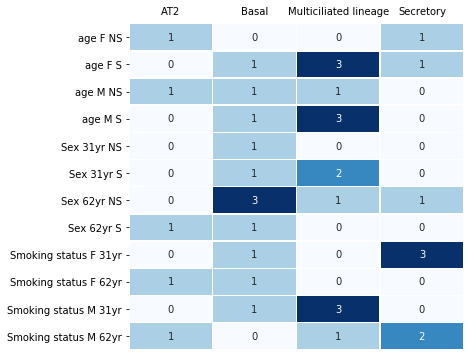

In [54]:
gene_mask = (res_summary_lvl3['gene'] == 'ACE2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT2', 'Basal', 'Multiciliated lineage', 'Secretory']))

ace2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity',''), ('eval_at','')]]
ace2_holdout_res['cov_eval'] = [' '.join([i1, i2]) for i1,i2 in zip(ace2_holdout_res[('covariate','')], ace2_holdout_res[('eval_at','')])]
ace2_holdout_res = ace2_holdout_res.pivot(index='cov_eval', columns='cell_identity')
ace2_holdout_res = ace2_holdout_res.drop(columns=['eval_at', 'covariate'])

ace2_holdout_res.columns = ace2_holdout_res.columns.get_level_values(2)
ace2_holdout_res.index = [item.replace('sex[T.male]', 'Sex').replace('smoking_status[T.True]', 'Smoking status') for item in ace2_holdout_res.index.tolist()]

rcParams['figure.figsize'] = (6,6)
p1 = sns.heatmap(ace2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ace2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ace2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Text(0, 0.5, 'age F NS'),
 Text(0, 1.5, 'age F S'),
 Text(0, 2.5, 'age M NS'),
 Text(0, 3.5, 'age M S'),
 Text(0, 4.5, 'Sex 31yr NS'),
 Text(0, 5.5, 'Sex 31yr S'),
 Text(0, 6.5, 'Sex 62yr NS'),
 Text(0, 7.5, 'Sex 62yr S'),
 Text(0, 8.5, 'Smoking status F 31yr'),
 Text(0, 9.5, 'Smoking status F 62yr'),
 Text(0, 10.5, 'Smoking status M 31yr'),
 Text(0, 11.5, 'Smoking status M 62yr')]

Text(5.999999999999993, 0.5, '')

Text(0.5, 33.0, '')

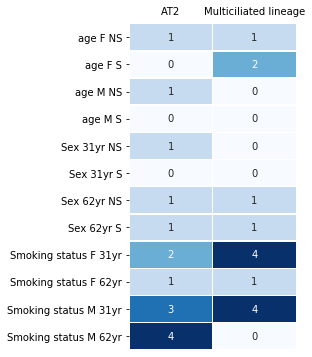

In [55]:
gene_mask = (res_summary_lvl3['gene'] == 'TMPRSS2')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT2', 'Multiciliated lineage']))

tmprss2_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity',''), ('eval_at','')]]
tmprss2_holdout_res['cov_eval'] = [' '.join([i1, i2]) for i1,i2 in zip(tmprss2_holdout_res[('covariate','')], tmprss2_holdout_res[('eval_at','')])]
tmprss2_holdout_res = tmprss2_holdout_res.pivot(index='cov_eval', columns='cell_identity')
tmprss2_holdout_res = tmprss2_holdout_res.drop(columns=['eval_at', 'covariate'])

tmprss2_holdout_res.columns = tmprss2_holdout_res.columns.get_level_values(2)
tmprss2_holdout_res.index = [item.replace('sex[T.male]', 'Sex').replace('smoking_status[T.True]', 'Smoking status') for item in tmprss2_holdout_res.index.tolist()]

rcParams['figure.figsize'] = (3,6)
p1 = sns.heatmap(tmprss2_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(tmprss2_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_tmprss2_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

/home/icb/malte.luecken/anaconda3/envs/cov19_py/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


[Text(0, 0.5, 'age F NS'),
 Text(0, 1.5, 'age F S'),
 Text(0, 2.5, 'age M NS'),
 Text(0, 3.5, 'age M S'),
 Text(0, 4.5, 'Sex 31yr NS'),
 Text(0, 5.5, 'Sex 31yr S'),
 Text(0, 6.5, 'Sex 62yr NS'),
 Text(0, 7.5, 'Sex 62yr S'),
 Text(0, 8.5, 'Smoking status F 31yr'),
 Text(0, 9.5, 'Smoking status F 62yr'),
 Text(0, 10.5, 'Smoking status M 31yr'),
 Text(0, 11.5, 'Smoking status M 62yr')]

Text(5.999999999999993, 0.5, '')

Text(0.5, 33.0, '')

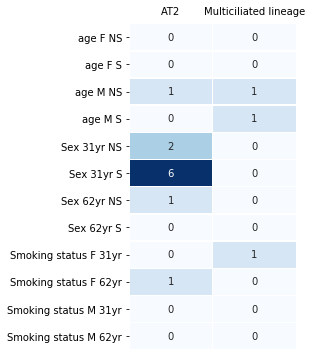

In [56]:
gene_mask = (res_summary_lvl3['gene'] == 'CTSL')
ct_mask = (res_summary_lvl3['cell_identity'].isin(['AT2', 'Multiciliated lineage']))

ctsl_holdout_res = res_summary_lvl3.loc[(gene_mask & ct_mask)][[('holdout_dataset_dis',''), ('covariate',''), ('cell_identity',''), ('eval_at','')]]
ctsl_holdout_res['cov_eval'] = [' '.join([i1, i2]) for i1,i2 in zip(ctsl_holdout_res[('covariate','')], ctsl_holdout_res[('eval_at','')])]
ctsl_holdout_res = ctsl_holdout_res.pivot(index='cov_eval', columns='cell_identity')
ctsl_holdout_res = ctsl_holdout_res.drop(columns=['eval_at', 'covariate'])

ctsl_holdout_res.columns = ctsl_holdout_res.columns.get_level_values(2)
ctsl_holdout_res.index = [item.replace('sex[T.male]', 'Sex').replace('smoking_status[T.True]', 'Smoking status') for item in ctsl_holdout_res.index.tolist()]

rcParams['figure.figsize'] = (3,6)
p1 = sns.heatmap(ctsl_holdout_res, cbar=False, cmap='Blues', annot=True, linewidths=.5)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
p1.set_yticklabels(ctsl_holdout_res.index, rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.savefig(folder+'/'+output_folder+de_output_base+'_annlvl3_ctsl_dataset_disagreements.pdf', dpi=300, bbox_inches='tight')
plt.show()
rcParams['figure.figsize'] = (8,8)

# Store results

In [58]:
res_summary_lvl2.columns = ['_'.join(col).strip('_') for col in res_summary_lvl2.columns.values]
res_summary_lvl3.columns = ['_'.join(col).strip('_') for col in res_summary_lvl3.columns.values]

In [59]:
res_summary_lvl2.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_summary.csv')
full_res_lvl2_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl2_full.csv')

In [60]:
res_summary_lvl3.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_summary.csv')
full_res_lvl3_glm.to_csv(folder+'/'+output_folder+de_output_base+'_lvl3_full.csv')